In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
from IPython.display import HTML

# Análisis de Señales 

En esta lección veremos

- Covarianza, correlación y convolución
- Transformada de Fourier discreta
- Transformada rápida de Fourier

## Notación

- Función de tiempo continuo: $g(t)$
- Función de tiempo discreto: $g[n] = g(t_n)$ con $t_n = n T_s, n\in [0, N]$
- Tiempo o intervalo de muestreo: $T_s$

En la siguiente figura se muestra una señal de tiempo continuo (linea gris) muestreada a tiempo regular (flechas rojas)

<img src="images/sampledsignal.png" width="600">


## Comparando señales en el tiempo

**Covarianza y correlación cruzada**

Podemos analizar la similitud entre dos señales $g(\cdot)$ y $f(\cdot)$ en función de un retardo $\tau$ usando el la covarianza cruzada

$$ 
\text{COV}_{gf}(\tau) = \mathbb{E}[(g(t)-\mu_g)(f(t + \tau)-\mu_f)], 
$$

y para procesos discretos con retardo $m$:

$$
\text{COV}_{gf}[m] = \frac{1}{N} \sum_{n=1}^N (g[n] - \bar g)(f[n+m] - \bar f),
$$

donde la media de la señal se estima como $ \bar g = \frac{1}{N} \sum_{n=1}^N g[n]$.

Si las señales tienen distinta escala es conveniente usar la correlación cruzada

$$ 
\rho_{gf}[m] = \frac{\text{COV}_{gf}[m]}{\hat \sigma_g \hat \sigma_f}, 
$$

donde la desviación estándar de la señal se estima como $\hat \sigma_g = \frac{1}{N} \sqrt{\sum_{n=1}^N (g[n] - \bar g)^2}$

```{note}
Podemos calcular la covarianza entre dos señales usando la función `np.correlate` de *NumPy*
```

**Ejemplo**

Usando la correlación  para encontrar el desfase o desplazamiento temporal relativo entre dos señales

'y1 está separado por -1.0101 segundos de y2'

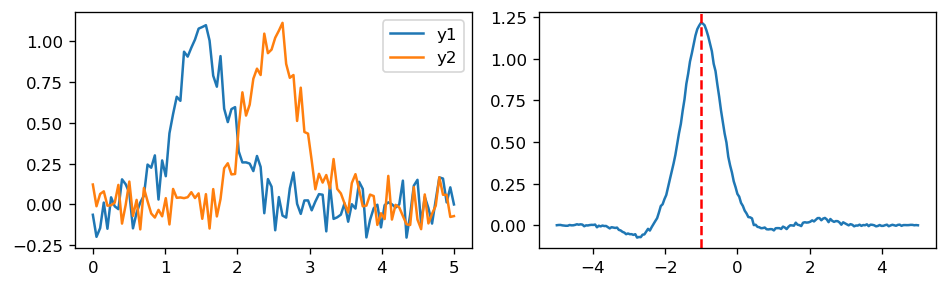

In [2]:
x = np.linspace(0.0, 5.0, num=100)
y1 = np.exp(-4.0*(x-1.5)**2) + 0.1*np.random.randn(len(x))
y2 = np.exp(-4.0*(x-2.5)**2) + 0.1*np.random.randn(len(x))
tau = np.linspace(-x[-1], x[-1], 2*len(x)-1)
crosscorr = np.correlate(y1, y2, mode='full')/(len(x)*np.std(y1)*np.std(y2))

fig, ax = plt.subplots(1, 2, figsize=(8, 2.5), tight_layout=True)
ax[0].plot(x, y1, label='y1')
ax[0].plot(x, y2, label='y2')
ax[0].legend()
ax[1].plot(tau, crosscorr);
idx_max = np.argmax(crosscorr)
display(f"y1 está separado por {tau[idx_max]:0.4f} segundos de y2")
ax[1].axvline(tau[idx_max], c='r', ls='--');

**Autocorrelación**

También es de interés comparar una señal consigo misma usando la autocorrelación 

$$ 
\rho_{gg}[m] = \frac{\text{COV}_{gg}[m]}{\hat \sigma_g^2}= \frac{1}{(N-m) \hat \sigma_g^2} \sum_{n=1}^{N-m} (g[n] - \bar g)(g[n+m] - \bar g), 
$$

Esto nos permite analizar en que momento $m$ la señal se parece más a si misma: **periodicidad**

**Ejemplo**

El período de la señal corresponde al segundo máximo de la autocorrelación

'El periodo (frecuencia fundamental de la señal es 1.0101 segundos'

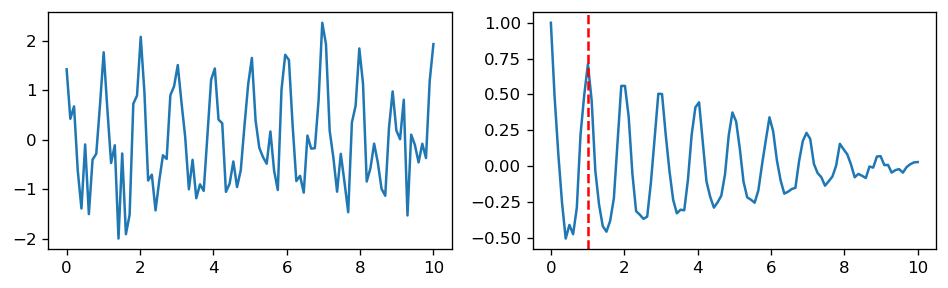

In [3]:
x = np.linspace(0.0, 10.0, num=100)
y = np.cos(2.0*np.pi*1*x) + 0.5*np.cos(2.0*np.pi*2*x) + 0.5*np.random.randn(len(x))

tau = np.linspace(0, x[-1], len(x))
autocorr = np.correlate(y, y, mode='full')[len(x)-1:]/(len(x)*np.var(y))

fig, ax = plt.subplots(1, 2, figsize=(8, 2.5), tight_layout=True)
ax[0].plot(x, y)
ax[1].plot(tau, autocorr)
ax[1].axvline(tau[1+np.argmax(autocorr[1:])], c='r', ls='--')
display(f"El periodo (frecuencia fundamental de la señal es {tau[1+np.argmax(autocorr[1:])]:0.4f} segundos")

**Convolución**

La operación de producto punto entre versiones desplazadas de funciones se llama **convolución** y se denota con $*$

$$
(f*g) (\tau) = \int g(t) f(\tau - t) \,dt = \int f(t) g(\tau - t) \,dt
$$


La convolución discreta se define como

$$
(f*g)[m] = \sum_n f[n] g[n-m]
$$

las funciónes de covarianza y correlación se pueden escribir como convoluciones

```{note}
Podemos realizar la convolución usando la función `np.convolve` de NumPy
```

**Ejemplo**

Convolución entre una señal cuadrada (naranja) y una Gaussiana (azul)

El resultado es una versión con bordes suavizados de la señal cuadrada (derecha)

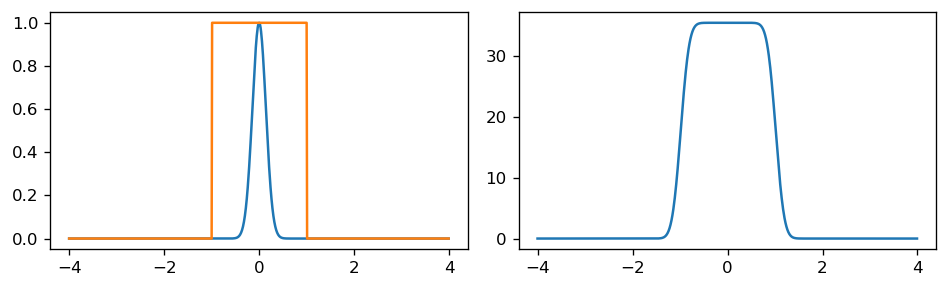

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(8, 2.5), tight_layout=True)

t = np.arange(-4, 4, step=1e-2)

def gaussian(t, a=0, s=0.2):
    return np.exp(-np.absolute(t-a)**2/s**2)

def square(t, a=0, T=1):
    s = np.zeros(shape=(len(t),))
    s[np.absolute(t-a) < T] = 1
    return s

conv_s = np.convolve(gaussian(t), square(t), mode='same')
ax[0].plot(t, gaussian(t))
ax[0].plot(t, square(t))
ax[1].plot(t, conv_s);

La siguiente animación muestra una representación gráfica de la convolución

El resultado de la convolución (derecha) es la integración del area que se marca en celeste en la figura de la izquierda

In [5]:
%%capture 
fig, ax = plt.subplots(1, 2, figsize=(8, 2.5), tight_layout=True)

def update(a = 0): 
    ax[0].cla(); ax[1].cla()
    p1, p2 = gaussian(t, 0.1*a - 4), square(t)
    ax[0].plot(t, p2); ax[0].plot(t, p1); 
    ax[0].fill_between(t, 0, p1*p2, alpha=0.5)
    ax[1].plot(t, conv_s[::-1]); ax[1].scatter(0.1*a -4, np.sum(p1*p2), s=100, c='k')
    return ()
    
anim = animation.FuncAnimation(fig, update, frames=80, interval=100, blit=True)

In [6]:
HTML(anim.to_html5_video())

## Análisis en frecuencia: Transformada de Fourier

Una herramienta de gran relevancia para el análisis de señales es la Transformada de Fourier

La transformada de Fourier de una señal $g(t)$ se define como

$$
\begin{align}
G(f) &= \mathcal{F}[g(t)] = \int_{-\infty}^{\infty} g(t) \exp(-j2\pi f t) \,dt \\
&= \int_{-\infty}^{\infty} g(t) \cos(2\pi f t) \,dt - j \int_{-\infty}^{\infty} g(t) \sin(2\pi f t) \,dt
\end{align}
$$

donde

- Usamos el operador $\mathcal{F}$ para denotar la transformada
- Tipicamente se usa $G$ para la transformación de $g$
- $G$ es ahora una función de la frecuencia

Usando la transformada de Fourier podemos analizar las frecuencias de oscilación predominantes de una señal

'Las frecuencias predominantes son: [1.  1.5] [Hz]'

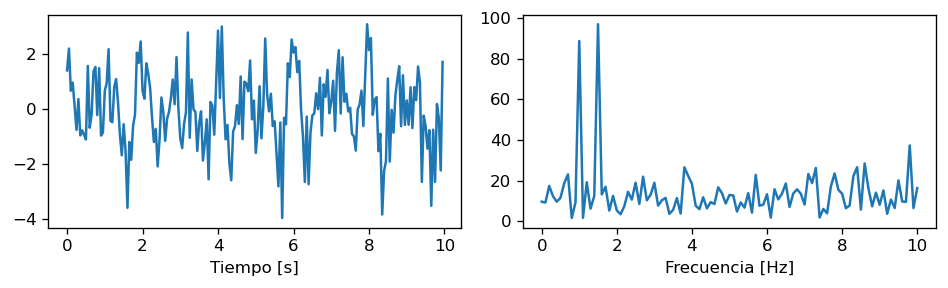

In [7]:
def matrix_DFT(signal):
    N = len(signal)
    W_N = np.exp(-1j*2*np.pi/N)
    n = np.arange(N)
    Omega = W_N**(n*n.reshape(1,-1).T)
    S = np.dot(Omega, signal)
    return np.dot(Omega, signal)

Fs = 20
t = np.arange(0.0, 10.0, step=1/Fs)
g = np.cos(2.0*np.pi*1*t) + np.cos(2.0*np.pi*1.5*t) + 1.0*np.random.randn(len(t))
f = np.linspace(0, Fs/2, num=len(t)//2+1)
Gabs = np.abs(matrix_DFT(g))

fig, ax = plt.subplots(1, 2, figsize=(8, 2.5), tight_layout=True)
ax[0].plot(t, g)
ax[0].set_xlabel("Tiempo [s]")
ax[1].plot(f, Gabs[:len(f)])
ax[1].set_xlabel("Frecuencia [Hz]");
display(f"Las frecuencias predominantes son: {f[Gabs[:len(f)] > 50]} [Hz]")

**Representación en coordenadas polares**

Es usual descomponer la transformada de Fourier en el espectro de amplitud y el espectro de fase

$$
G(f) = |G(f)| \exp({j\varphi(f)})
$$

Donde 

- $|G(f)|$ es el espectro de amplitud
-  $\varphi(f)$ es el espectro de fase (ángulo)

**Propiedad:** La transformada de Fourier es invertible

$$
\begin{align}
g(t) &= \mathcal{F}^{-1}[G(f)] =\int_{-\infty}^{\infty} G(f) \exp(j2\pi f t) \,df \\
&= \int_{-\infty}^{\infty} G(f) \cos(2\pi f t) \,df + j \int_{-\infty}^{\infty} G(f) \sin(2\pi f t) \,df
\end{align}
$$

**Propiedad:** La convolución en el tiempo se convierte en multiplicación en frecuencia y viceverza (Lathi & Ding, 2009, Sec 3.3.6)

$$
\mathcal{F}[g(t)*y(t)] = \mathcal{F}[g(t)] \mathcal{F}[y(t)] = G(f) Y(f)
$$

**Propiedad:** La transformada de Fourier es un operador lineal

$$
\begin{align}
\mathcal{F}[a g_1(t) + b g_2(t) ] &= a\mathcal{F}[g_1(t)] + b \mathcal{F}[g_2(t) ] \\ &= a G_1(f) + b G_2(f)
\end{align}
$$

**Teorema:** (de) Parseval: 

La energía de una señal se preserva. La transformada de Fourier no pierde información. (Lathi & Ding, 2009, Sec 3.7.1)

$$
\int_{-\infty}^{\infty} |g(t)|^2 \,dt = \int_{-\infty}^{\infty} |G(f)|^2 \,df
$$


**Teorema:** (de) Wiener-Khinchin:

La transformada de Fourier de la autocorrelación es la *densidad espectral de potencia* y viceverza (Lathi & Ding, 2009, 3.7.5)

$$
|G(f)|^2 = \int_{-\infty}^{\infty} \rho_{gg}(\tau) \exp({-j2\pi f \tau }) \,dt = \mathcal{F}[\rho_{gg}(\tau)]
$$

$$
\rho_{gg}(\tau) = \int_{-\infty}^{\infty} |G(f)|^2 \exp({j2\pi\tau f}) \,df  = \mathcal{F}^{-1}[|G(f)|^2]
$$

La densidad espectral es la potencia asignada a cada frecuencia de la señal

### Transformada de Fourier discreta (DFT)

Para computar la transformada de Fourier sobre señales muestreadas (discretas) usamos la DFT

El resultado es una transformada de Fourier definida en un conjunto discreto de frecuencias

Sea una señal discreta $g[n]$ con  $n \in [0, N-1]$ y tiempo de muestreo $T_s$, es decir $t[n] = n T_s$

La DFT se define como

$$
G[k] = \sum_{n=0}^{N-1} g[n]  \exp \left(-j2\pi f[k] t[n] \right) = \sum_{n=0}^{N-1} g[n] \exp \left( -j 2\pi \frac{k n}{N} \right) ,
$$

donde 

- $f[k] = k f_0 ~~ \forall k \in [-\frac{(N-1)}{2}, \frac{(N-1)}{2}]$
- $f_0 = \frac{F_s}{N}$
- $F_s = \frac{1}{T_s}$
- $t[n] = n T_s$

La DFT es también invertible

$$
g[n] = \frac{1}{N} \sum_{k=0}^{N-1} G[k]  \exp \left( j2\pi \frac{k n}{N} \right)
$$

Notar que N puntos en el tiempo se mapean con N frecuencias independientes

Para tener una notación más clara definiremos

$$
W_N = \exp \left( -j \frac{2\pi}{N} \right)
$$

Luego podemos escribrir la DFT como

$$
G[k] = \sum_{n=0}^{N-1} g[n] W_N^{kn}
$$

Podemos escribir el sistema de ecuaciones

$$
G[k] = \sum_{n=0}^{N-1} g[n] W_N^{kn}
$$

en **forma matricial** como

$$
\begin{align}
\begin{pmatrix} 
G[0] \\
G[1] \\
G[2] \\
\vdots \\
G[N-1] \\
\end{pmatrix} &=
\begin{pmatrix}
1 & 1 & 1 & \cdots & 1 \\
1 & W_N & W_N^2 & \cdots & W_N^{N-1} \\
1 & W_N^2 & W_N^4 & \cdots & W_N^{N-2} \\
\vdots & \dots & \dots & \ddots &  \vdots \\
1 & W_N^{N-1} & W_N^{N-2} & \cdots & W_N \\
\end{pmatrix} 
\begin{pmatrix} 
g[0] \\
g[1] \\
g[2] \\
\vdots \\
g[N-1] \\
\end{pmatrix} \nonumber  \\
G &= \Omega g,
\end{align}
$$

que corresponde a $N$ tiempos definidos como 

$$
t = 0, ~ T_s, ~2 T_s , ~3 T_s, \ldots, ~(N-1) T_s 
$$

y a $N$ frecuencias definidas como

$$
f = -\frac{F_s}{2}, \ldots,  0, ~\frac{F_s}{N}, ~2 \frac{F_s}{N} , ~3 \frac{F_s}{N}, \ldots, ~\frac{F_s}{2} 
$$



En el ejemplo anterior implementamos la DFT como una multiplicación matricial usando Numpy

- Multiplicación entre una matriz de NxN y un vector de Nx1
- N sumas de N multiplicaciones, complejidad cuadrática


In [8]:
def matrix_DFT(signal):
    N = len(signal)
    W_N = np.exp(-1j*2*np.pi/N)
    n = np.arange(N)
    Omega = W_N**(n*n.reshape(1,-1).T)
    S = np.dot(Omega, signal)
    return S

### Transformada rápida de Fourier o FFT

La computación de la DFT tiene complejidad $\mathcal{O}(N^2)$

```{note}
Existen varios algoritmos exactos con complejidad $\mathcal{O}(N\log N)$ para calcular la DFT: La *Fast Fourier Transform* (FFT)
```

El algoritmo de FFT más conocido es el de Cooley-Tukey, en donde se obtiene una FFT recursiva que explota las periodicidades en la matriz $\Omega$

$$
\begin{align}
G[k] &=  \sum_{n=0}^{N-1} g_n \exp \left(-j2\pi \frac{k n}{N} \right) \\
&= \sum_{n=0}^{N/2-1} g_{2n} \exp \left(-j2\pi \frac{k 2n}{N}  \right) + \sum_{n=0}^{N/2-1} g_{2n+1} \exp \left(-j2\pi \frac{k (2n+1)}{N} \right) \\
&= \sum_{n=0}^{N/2-1} g_{2n} \exp \left(-j2\pi \frac{k n}{N/2} \right) + \exp \left(-j2\pi  \frac{k}{N} \right) \sum_{k=0}^{N/2-1} g_{2n+1} \exp \left(-j2\pi \frac{k n}{N/2} \right) \\ 
&= G_E[k] + \exp \left( -j2\pi \frac{k}{N} \right) G_O[k] ~~ \forall k \in [0,N/2] 
\end{align} 
$$

Notar que se calculan dos "medias" DFT

Para continuar usaremos la siguiente propiedad de la exponencial compleja

$$
 \exp \left(-j2\pi \frac{k+ N/2}{N}\right) = \exp \left(-j2\pi \frac{k}{N} \right) \exp \left(-j\pi\right) =  - \exp \left(-j2\pi \frac{k}{N} \right)
$$

Además por periodicidad/simetría de la DFT

$$
\begin{align}
G_E[k + N/2] &=  \sum_{n=0}^{N/2-1} g_{2n} \exp \left( -j2\pi \frac{(k+ N/2)n}{N/2} \right) \\
&= \sum_{n=0}^{N/2-1} g_{2n} \exp \left(-j2\pi \frac{k n}{N/2} \right)  \exp \left(-j2\pi n \right) = G_E[k]
\end{align}
$$
Finalmente

$$
\begin{align}
G[k] &=  G_E[k] + \exp \left( -j2\pi \frac{k}{N} \right) G_O[k] ~~~ \forall k \in [0,N/2] \\
G[k + N/2] &=  G_E[k + N/2] - \exp \left( -j2\pi \frac{k}{N} \right) G_O[k + N/2] \\
 &=  G_E[k] - \exp \left( -j2\pi \frac{k}{N} \right) G_O[k] \\
\end{align}
$$

**En resumen**

Para obtener $G[k]$ y $G[k + N/2]$:

- Calculamos $G_E[k]$ y $ \exp \left( -j2\pi \frac{k}{N} \right) G_O[k]$ 
- Sumamos o restamos los términos, respectivamente

Es decir que reducimos los cálculos necesarios a la mitad


**Ejemplo**

Sea una señal aleatoria con dias muestras

Calculemos y comparemos la DFT de los pares (puntos naranjos) e impares (cruces azules)

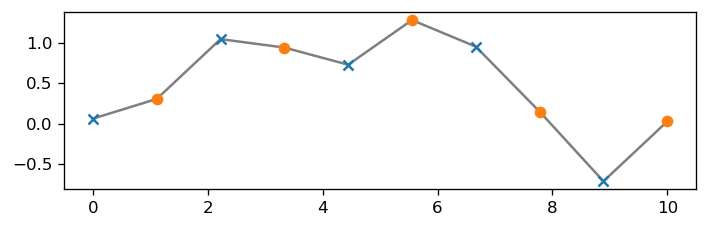

In [9]:
t = np.linspace(0, 10, num=10)
x = np.random.randn(len(t))
plt.figure(figsize=(6, 2), tight_layout=True)
plt.plot(t, x, c='k', alpha=0.5)
plt.scatter(t[::2], x[::2], marker='x', zorder=100)
plt.scatter(t[1::2], x[1::2], marker='o', zorder=100);

La función `np.close` retorna `True` si todos los elementos de los arreglos tienen una diferencia menor a `1e-8`

In [10]:
np.set_printoptions(precision=3)
N = len(x)
W_N = np.exp(-1j*2*np.pi/N)

S = matrix_DFT(x)
Se = matrix_DFT(x[0::2]) # Transformada de Fourier de los pares
So = matrix_DFT(x[1::2]) # Transformada de Fourier de los impares
display(S[:N//2], Se + W_N**np.arange(N//2)*So)
display(np.allclose(S[:N//2], Se + W_N**np.arange(N//2)*So))
display(S[N//2:], Se - W_N**np.arange(N//2)*So)
display(np.allclose(S[N//2:], Se - W_N**np.arange(N//2)*So))

array([ 4.771+0.j   , -2.542-2.455j,  0.814-1.043j, -0.19 +1.447j,
        0.153+0.623j])

array([ 4.771+0.j   , -2.542-2.455j,  0.814-1.043j, -0.19 +1.447j,
        0.153+0.623j])

True

array([-0.627-2.642e-16j,  0.153-6.228e-01j, -0.19 -1.447e+00j,
        0.814+1.043e+00j, -2.542+2.455e+00j])

array([-0.627+0.j   ,  0.153-0.623j, -0.19 -1.447j,  0.814+1.043j,
       -2.542+2.455j])

True

El algoritmo FFT continua dividiendo en pares hasta llegar a $N\log N$ productos, como muestra la siguiente figura

<img src="images/FFT.gif" width="600">

## Implementaciones de la FFT 

- Python: numpy.fft y [scipy.fft](https://docs.scipy.org/doc/scipy/tutorial/fft.html)
- C: The Fastest Fourier Transform in the WEst (FFTW)
- OpenCV: Enfocado en señales bidimensionales (lo veremos más adelante)

En lo que sigue usaremos:

<img src="images/fftpack_scipy.png" width="600">

**Funciones principales** 

Para obtener la transformada de Fourier usando el modulo `fft` de scipy usamos 

- `fft.fft` y `fft.ifft`: Calcula la transformada y la transformada inversa (caso general)
- `fft.rfft` y `fft.irfft`: Calcula la transformada y la transformada inversa para señales con valores reales
- `fft.fftfreq` y `fft.rfftfreq`:  Crea una arreglo de frecuencias consistente con las funciones anteriores


In [11]:
import scipy.fft

**Ejemplo:** Comparación entre implementación matricial usando NumPy y FFT de scipy

Primero creamos una serie de tiempo con frecuencia de muestreo $F_s$

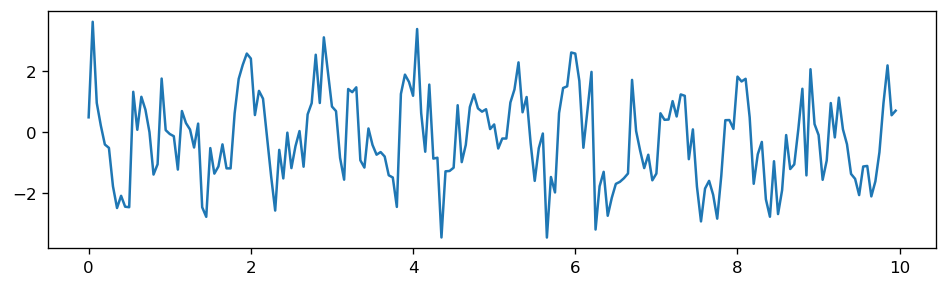

In [12]:
Fs = 20
t = np.arange(0.0, 10.0, step=1/Fs)
g = np.cos(2.0*np.pi*1*t) + np.cos(2.0*np.pi*1.5*t) + 1.0*np.random.randn(len(t))
fig, ax = plt.subplots(figsize=(8, 2.5), tight_layout=True)
ax.plot(t, g);

Para calcular la FFT usamos

In [13]:
G = scipy.fft.rfft(g)
display(G[:10])

array([-40.159 +0.j   , -18.56 -31.249j,   5.084 +3.316j,  -0.89 +15.197j,
        18.825 -8.57j ,  -1.823 +9.025j,  -2.887 -6.027j,  11.564 -8.763j,
        -6.345 +5.115j, -16.713+11.074j])

La FFT es imaginaria, podemos recuperar 
- el espectro de magnitud usando la función `np.abs`
- el espectro de fase usando `np.angle`

Para generar el vector de frecuencias asociado a la FFT usamos

In [14]:
freq = scipy.fft.rfftfreq(n=len(g), d=1/Fs)
display(freq[:10])

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

Finalmente dibujamos los espectros de magnitud

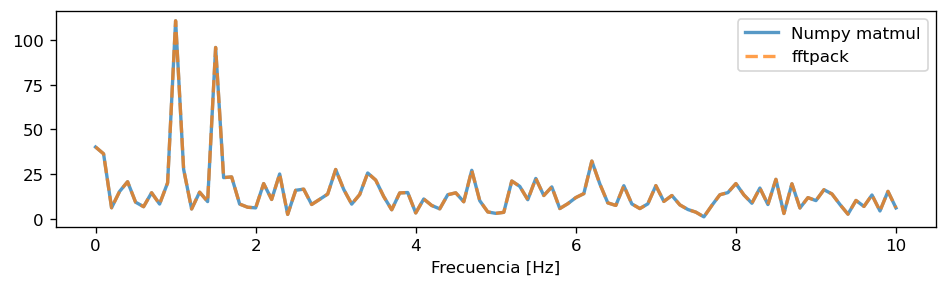

In [15]:
fig, ax = plt.subplots(figsize=(8, 2.5), tight_layout=True)
ax.plot(freq, np.abs(matrix_DFT(g))[:len(freq)], label='Numpy matmul', alpha=.75, lw=2)
ax.plot(freq, 
        np.abs(scipy.fft.rfft(g)), label='fftpack', alpha=.75, lw=2, ls='dashed')
ax.set_xlabel("Frecuencia [Hz]")
plt.legend(loc=1);

y comparamos los tiempos de cómputo

¿Cuántos órdenes de magnitud más rápido es la FFT?

In [16]:
%timeit -n 10 np.abs(matrix_DFT(g))
%timeit -n 10 np.abs(scipy.fft.fft(g))

35.6 ms ± 3.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 4.22 times longer than the fastest. This could mean that an intermediate result is being cached.
51.1 µs ± 38.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
